<a href="https://colab.research.google.com/github/Omid-Hassasfar/QIran-s-QProject-101_05-VQE/blob/main/2_VQE_H3_Chain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qiskit[visulization]
!pip install pyscf
!pip install qiskit-nature

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 31.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.5/241.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 37.5/37.5 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 119.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [2]:
import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.24.1', 'qiskit-aer': '0.12.1', 'qiskit-ignis': None, 'qiskit-ibmq-provider': '0.20.2', 'qiskit': '0.43.2', 'qiskit-nature': '0.6.2', 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

In [3]:
import qiskit_nature
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
from qiskit_nature.second_q.transformers import FreezeCoreTransformer
from qiskit_nature.second_q.formats.molecule_info import MoleculeInfo
from qiskit_nature.second_q.mappers import ParityMapper
from qiskit_nature.second_q.circuit.library import UCCSD, HartreeFock
from qiskit.algorithms.optimizers import SPSA, SLSQP
import numpy as np
qiskit_nature.settings.use_pauli_sum_op = False
from qiskit_nature.second_q.drivers import PySCFDriver
import matplotlib.pyplot as plt
from qiskit.circuit.library import EfficientSU2
from qiskit_aer.primitives import Estimator

---
---
# Hydrogen Chain ( $H_3$ )
---
---

In [4]:
# Hydrogen Molecule

def get_qubit_op(dist):
    # Define Molecule
    molecule = MoleculeInfo(
        # Coordinates in Angstrom
        symbols=["H", "H" , "H"],
        coords=( [-dist, 0.0, 0.0], [0.0, 0.0, 0.0], [dist, 0.0, 0.0]),
        multiplicity= 2 ,  # = 2*spin + 1
        charge=0,
    )
    driver = PySCFDriver.from_molecule(molecule)

    # Get properties
    properties = driver.run()

    # Now you can get the reduced electronic structure problem
    problem = FreezeCoreTransformer(
       freeze_core=True, remove_orbitals=[-3, -2]
  ).transform(properties)

    num_particles = problem.num_particles
    num_spatial_orbitals = problem.num_spatial_orbitals

    mapper = ParityMapper(num_particles=num_particles)
    qubit_op = mapper.map(problem.second_q_ops()[0])
    return qubit_op, num_particles, num_spatial_orbitals, problem, mapper

In [5]:
%%time

def exact_solver(qubit_op, problem):
    sol = NumPyMinimumEigensolver().compute_minimum_eigenvalue(qubit_op)
    result = problem.interpret(sol)
    return result


distances = np.arange(0.3, 2.1, 0.05)
exact_energies = []
vqe_energies = []
optimizer = SLSQP(maxiter=10)
noiseless_estimator = Estimator(approximation=True)
for dist in distances:
    (qubit_op, num_particles, num_spatial_orbitals, problem, mapper) = get_qubit_op(
        dist
    )

    result = exact_solver(qubit_op, problem)
    exact_energies.append(result.total_energies[0].real)
    init_state = HartreeFock(num_spatial_orbitals, num_particles, mapper)
    var_form = UCCSD(
        num_spatial_orbitals, num_particles, mapper, initial_state=init_state
    )
    vqe = VQE(
        noiseless_estimator,
        var_form,
        optimizer,
        initial_point=[0] * var_form.num_parameters,
    )
    vqe_calc = vqe.compute_minimum_eigenvalue(qubit_op)
    vqe_result = problem.interpret(vqe_calc).total_energies[0].real
    vqe_energies.append(vqe_result)
    print(
        f"Interatomic Distance: {np.round(dist, 2)}",
        f"VQE Result: {vqe_result:.5f}",
        f"Exact Energy: {exact_energies[-1]:.5f}",
    )

print("All energies have been calculated")

/usr/local/lib/python3.10/dist-packages/pyscf/dft/libxc.py:772: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, the same to the B3LYP functional in Gaussian and ORCA (issue 1480). To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


Interatomic Distance: 0.3 VQE Result: 0.11719 Exact Energy: 0.11719
Interatomic Distance: 0.35 VQE Result: -0.39705 Exact Energy: -0.39705
Interatomic Distance: 0.4 VQE Result: -0.74874 Exact Energy: -0.74875
Interatomic Distance: 0.45 VQE Result: -0.99501 Exact Energy: -0.99501
Interatomic Distance: 0.5 VQE Result: -1.17053 Exact Energy: -1.17053
Interatomic Distance: 0.55 VQE Result: -1.29700 Exact Energy: -1.29700
Interatomic Distance: 0.6 VQE Result: -1.38832 Exact Energy: -1.38832
Interatomic Distance: 0.65 VQE Result: -1.45379 Exact Energy: -1.45379
Interatomic Distance: 0.7 VQE Result: -1.49994 Exact Energy: -1.49994
Interatomic Distance: 0.75 VQE Result: -1.53150 Exact Energy: -1.53150
Interatomic Distance: 0.8 VQE Result: -1.55203 Exact Energy: -1.55203
Interatomic Distance: 0.85 VQE Result: -1.56418 Exact Energy: -1.56418
Interatomic Distance: 0.9 VQE Result: -1.56998 Exact Energy: -1.56998
Interatomic Distance: 0.95 VQE Result: -1.57098 Exact Energy: -1.57098
Interatomic Dis

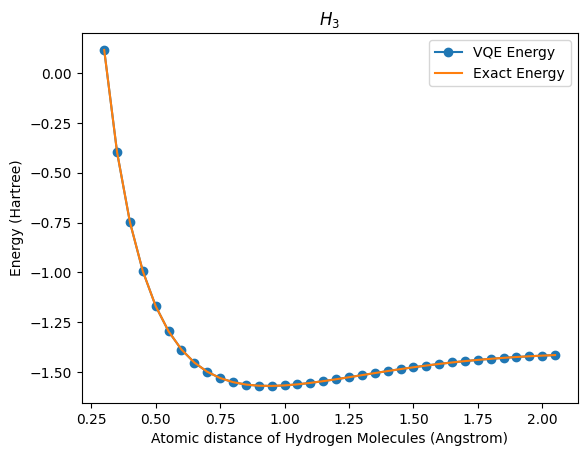

In [6]:
plt.plot(distances, vqe_energies , 'o-'  , label="VQE Energy")
plt.plot(distances, exact_energies, label="Exact Energy")
plt.xlabel("Atomic distance of Hydrogen Molecules (Angstrom)")
plt.ylabel("Energy (Hartree)")
plt.title('$H_3$')
plt.legend()
plt.show()